<a href="https://colab.research.google.com/github/AnthonyJFeola/DS-Unit-2-Kaggle-Challenge/blob/master/module4-classification-metrics/LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')
train.shape, test.shape

((59400, 41), (14358, 40))

In [0]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

In [4]:
train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [5]:
train['status_group'].value_counts(normalize=True)

functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64

In [0]:
import numpy as np
def wrangle(X):   
    X = X.copy()
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    cols_with_zeros = ['longitude', 'latitude']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)

    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    return X
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
target = 'status_group'

In [0]:
# Dropped: 'date_recorded', 'funder', 'installer', 'wpt_name', 'subvillage', 
#          'lga', 'ward', 'scheme_name', 'amount_tsh', 'num_private', 'id', 
#          'status_group', 'quantity_group'

features = ['gps_height', 'longitude', 'latitude',
       'basin', 'region', 'region_code', 'district_code',
       'population', 'public_meeting', 'scheme_management', 'permit', 
       'construction_year', 'extraction_type', 'extraction_type_group', 
       'extraction_type_class', 'management', 'management_group', 'payment', 
       'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 
       'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'year_recorded', 'month_recorded', 'day_recorded', 'years', 'years_MISSING']

In [0]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [0]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.preprocessing import OneHotEncoder

In [11]:
%%time
pipeline = make_pipeline(
    ce.OneHotEncoder(),
    SimpleImputer(),
    StandardScaler(),
    SelectKBest(),
    RandomForestClassifier(random_state=42)
)

param_distributions = { 
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestclassifier__n_estimators': randint(50, 500), 
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None], 
    'randomforestclassifier__max_features': uniform(0, 1),
    'selectkbest__k': [150, 200, 300]
}

search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=10, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  7.1min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 35.6min
[Parallel(n_jobs=-1)]: Done 

CPU times: user 1min 4s, sys: 677 ms, total: 1min 5s
Wall time: 48min 35s


In [12]:
print('Best Hyperparameters', search.best_params_)
print('Accuracy', search.best_score_)

Best Hyperparameters {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_features': 0.7106054874778127, 'randomforestclassifier__n_estimators': 91, 'selectkbest__k': 150, 'simpleimputer__strategy': 'mean'}
Accuracy 0.8048400673400673


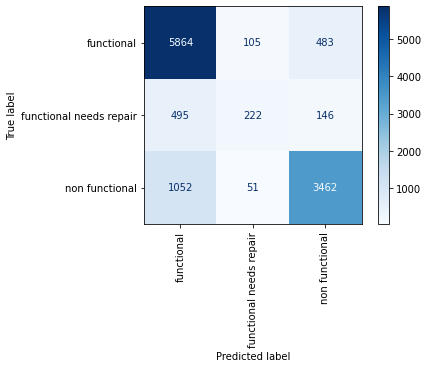

In [13]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(search, X_val, y_val, 
                      xticks_rotation='vertical', 
                      values_format='.0f',
                      cmap='Blues');

In [0]:
y_pred = search.predict(X_test)
sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('Anthony_Feola_DS_221.csv', index=False)